# Курс «Глубокое обучение в компьютерном зрении»

Урок 4. Семантическая сегментация

## <font color='red'>Практическое задание 4</font>

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO<br>
Библиотеки: [Python, Tensorflow]

Выполнил ___Соковнин ИЛ___

## Переключение версии TensorFlow

In [3]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf

# gpu_device = tf.config.experimental.list_physical_devices('GPU')
# if gpu_device:
#     tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [5]:
!ls

sample_data


## Загрузка датасета COCO и COCO API

In [24]:
# if 1:
# !mkdir -p data

# !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip
#  # Архив с анотациями (разметкой)
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# # Библиотека для работы с натациями датасета COCO
# !cd data && git clone https://github.com/cocodataset/cocoapi
# # Собираем и подготавливаем библиотеку к работе
# !cd data/cocoapi/PythonAPI && make

In [34]:
# !rm -rf data/train2017
# !rm /data/train2017.zip
# !du ./data/train2017
# !du ./data/

## Подготовка COCO API

In [35]:
# Импортируем библиотеку для чтения нотации и работы с ней
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

Подготавливаем pipeline данных для сегментации

In [36]:
class Dataset():
    # Создаём универсальный класс для произвольной сегментации
    
    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):
        # Создание обучающего датасета
        # Для яобъединения картинок в batch они д.б. одного, фиксированного размера
        # Для обучения берём случайный crop на картинке
        # Аугментация

        def item_to_images(item):
            # Чтение картинки с диска
            # item - указание на то, где находится картинка
            
            random_crop = True
            
            # Для чтения используется ф-я read_images,
            # которая д.б. реализована в дочернем классе
            # img_combined - выход, комбинированная картинка,
            # где по канальному измерению сконкатенирована наша исходная картинка rgb
            # и картинка с метками класса. Все картинки имеют тип int8.
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            # Вызываем кроп для неё (см. выше ф-ю crop_images )
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            # Исходная картинка
            # предполагаем, что она находится в первых 3-х каналах
            # Мы считаем, что функция read_images нам возвращает
            # в первых 3-х каналах картинку
            # а в последнем карту сегментации
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)

            # Карта сегментации (находится в последнем канале)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)  

            return img, mask_class  # картинка и маска

        
        # img_list - список путей к файлам с картинками
        # Из этого списка путей к картинкам создаём датасет
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        # Перемешиваем его
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        # Для каждого элемента датасета применяем функцию item_to_images
        # подлучаем картинка и её маску
        dataset = dataset.map(item_to_images)  # датасет с картинками
        dataset = dataset.repeat(epochs)  # repead по количеству эпох
        dataset = dataset.batch(batch_size, drop_remainder=True)  # batch

        return dataset  # Получаем датасет для дальнейшей работы

    def val_dataset(self, batch_size, inp_size):
        # Создание валидационного датасета
        # Для яобъединения картинок в batch они д.б. одного размера
        # Для валидации делаем центральный crop

        def item_to_images(item):
            # То же самое, что и для train
            # Но у нас random_crop = False и
            # мы не делаем repeat по эпохам
            
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [37]:
class COCO_Dataset(Dataset):
    # Наследуемся от универсального класса и создаём класс для датасета COCO
    # Кастомный, специальный способ загрузки изображений

    def __init__(self, sublist):
        # Специфичный для COCO конструктор
        
        # Путь к разметке
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        
        # Инициализируем класс COCO (используем COCO-api)
        self.coco = COCO(ann_file_fpath)
        
        # Указываем какие категории мы хотим использовать. 
        # Можно указать список категорий ['person', ...]
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        # Получаем картинки с категориями
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    # Ф-я по элементу списка img_list получает картинку и маски
    # У картинки м.б. несколько масок. Каждая сидит в отдельном слое.
    # Мы их все суммируем
    def read_images(self, img_id):
        # Функция чтения изображения
        # Функция read_images обязательно должна нам возврать,
        # в первых 3-х каналах картинку, а в последнем карту сегментации.
        # Логика специфичная для COCO
        
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        
        # Суммируем все маски у картинки
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined  # Полученная исходная картинка

In [38]:
# Создаем экземпляры класса валидационный и трэйн датасеты
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=19.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


Уменьшим количество изображений в датасете, стобы модель обучилась за разумное время.

In [93]:
COCO_dataset_train.cat_ids=COCO_dataset_train.cat_ids[:1000]
COCO_dataset_train.img_list=COCO_dataset_train.img_list[:1000]

COCO_dataset_val.cat_ids=COCO_dataset_val.cat_ids[:200]
COCO_dataset_val.img_list=COCO_dataset_val.img_list[:200]

In [94]:
len(COCO_dataset_train.img_list), len(COCO_dataset_train.cat_ids)

(1000, 1)

In [95]:
len(COCO_dataset_val.img_list), len(COCO_dataset_val.cat_ids)

(200, 1)

In [96]:
NUM_EPOCHS = 10
BATCH_SIZE = 8
inp_size = 256

In [97]:
# Сформируем валлидационный и тестовый tf датасеты.

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,inp_size=inp_size)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=inp_size)

## Визуализация датасета 

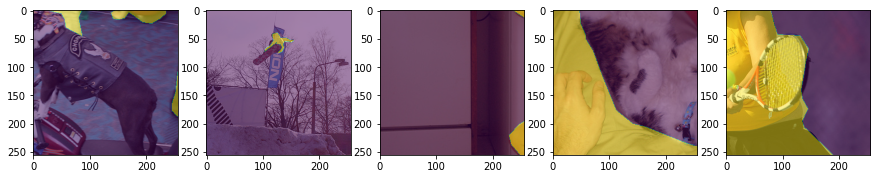

In [98]:
# Выполним визуализацию 
# %matplotlib inline
# import matplotlib.pyplot as plt

img, mask = next(iter(train_ds.take(1)))

fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask[...,0][i],alpha=0.5)
plt.show()

# Используем функциональный способ построения модели

In [99]:
# U-Net
def build_model():
    # 4 раза понижаем разрешение, затем 4 раза повышаем разрешение
    x = tf.keras.layers.Input((inp_size, inp_size, 3))  # Входной узел - указываем размер картинки 256x256x3
    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Визуализация U-Net
Визуализируем граф

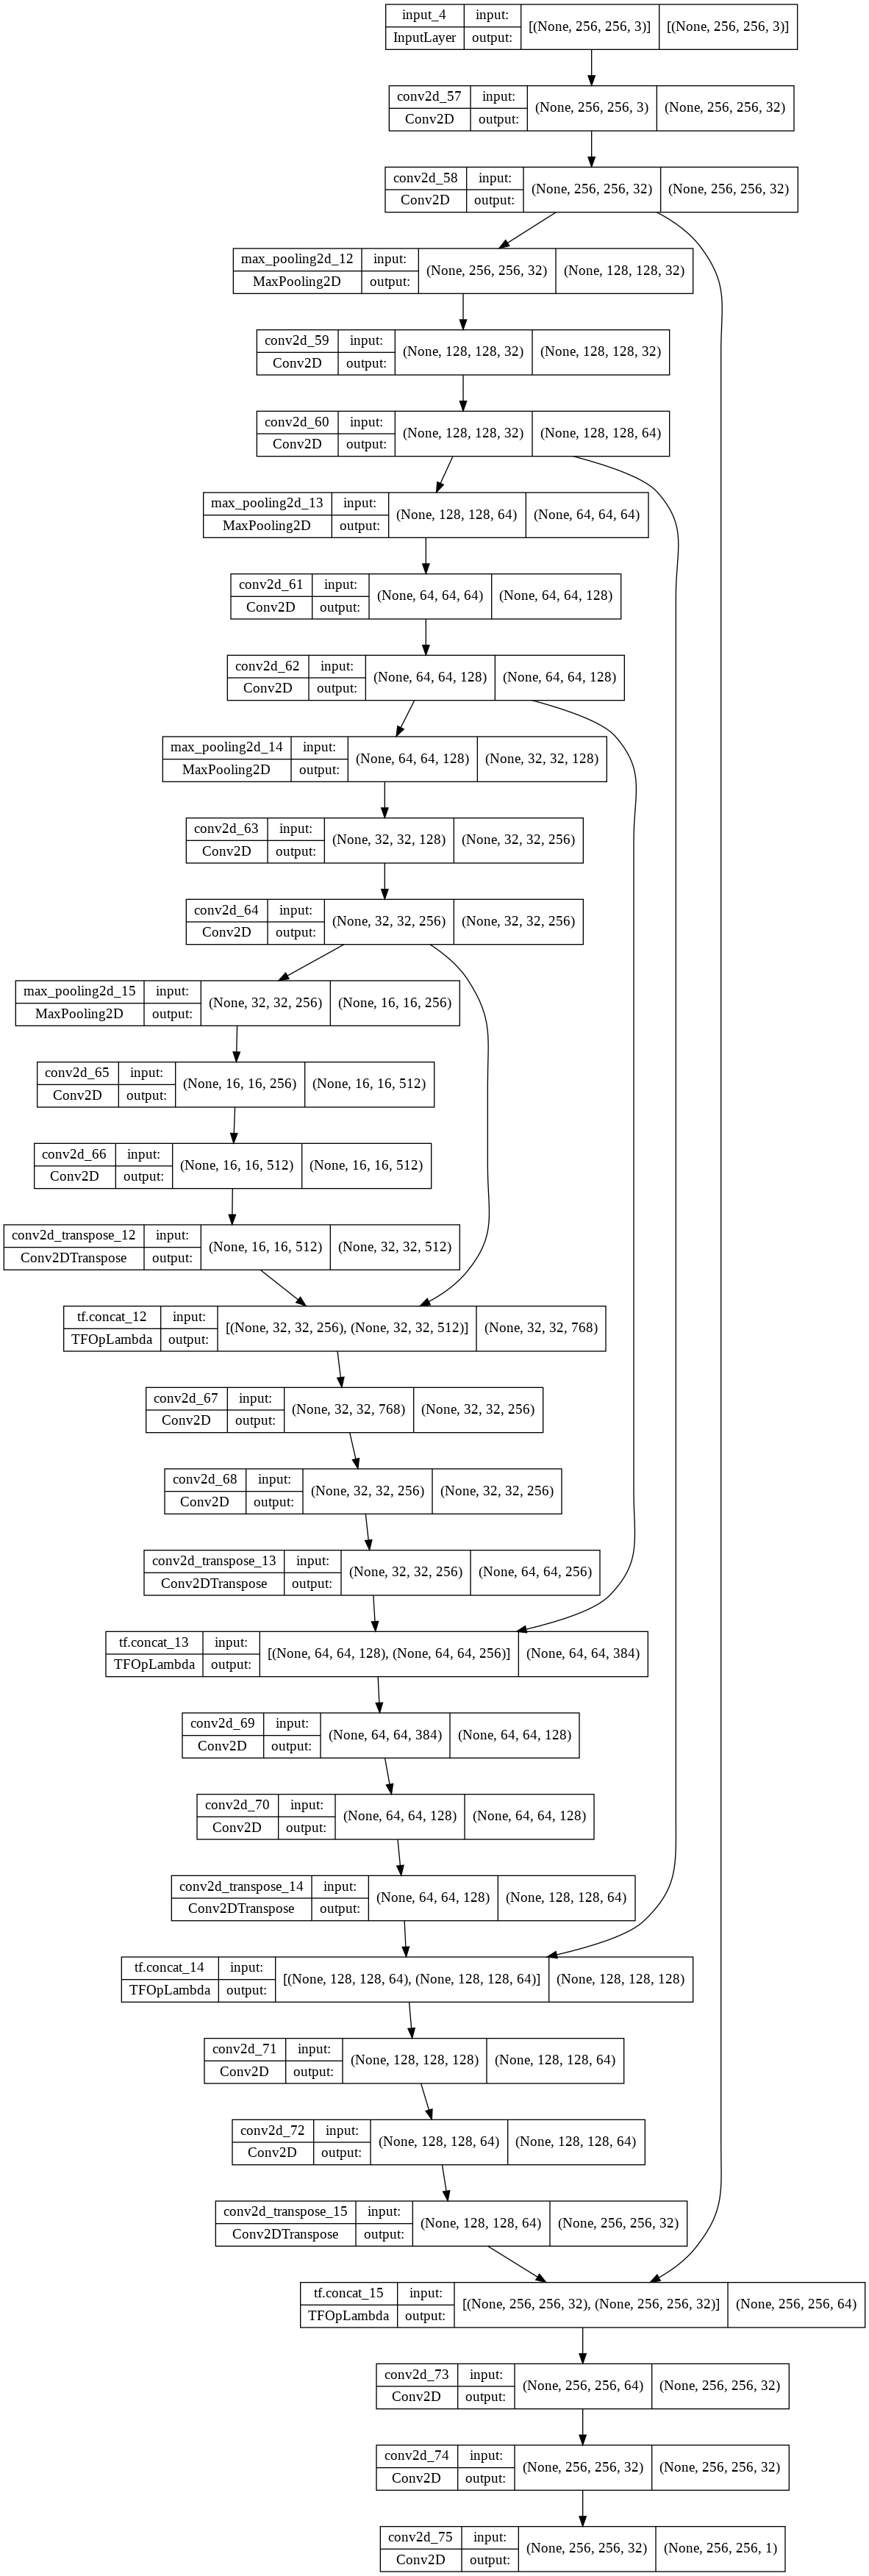

In [100]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

In [101]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 8

# Нам нужно сделать дополнительное суммирование или усреднение 
# по пространственным измерения карты признаков.
# За нас это делает ф-я BinaryCrossentropy().
loss = tf.keras.losses.BinaryCrossentropy()  
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [102]:
# NUM_EPOCHS = 10

hist = model.fit(train_ds, 
                 batch_size=BATCH_SIZE,
                 epochs=NUM_EPOCHS,
                 validation_data=val_ds,
                 )

Epoch 1/10
1250/1250 [==============================] - 387s 309ms/step - loss: 0.4828 - accuracy: 0.7875 - val_loss: 0.5068 - val_accuracy: 0.7573
Epoch 2/10
1250/1250 [==============================] - 384s 307ms/step - loss: 0.4606 - accuracy: 0.7905 - val_loss: 0.4813 - val_accuracy: 0.7781
Epoch 3/10
1250/1250 [==============================] - 384s 307ms/step - loss: 0.4359 - accuracy: 0.7967 - val_loss: 0.4639 - val_accuracy: 0.7697
Epoch 4/10
1250/1250 [==============================] - 384s 307ms/step - loss: 0.4153 - accuracy: 0.8059 - val_loss: 0.4472 - val_accuracy: 0.7849
Epoch 5/10
1250/1250 [==============================] - 382s 306ms/step - loss: 0.4070 - accuracy: 0.8106 - val_loss: 0.4443 - val_accuracy: 0.7879
Epoch 6/10
1250/1250 [==============================] - 383s 307ms/step - loss: 0.4019 - accuracy: 0.8122 - val_loss: 0.4285 - val_accuracy: 0.7886
Epoch 7/10
1250/1250 [==============================] - 382s 305ms/step - loss: 0.3970 - accuracy: 0.8148 - val_

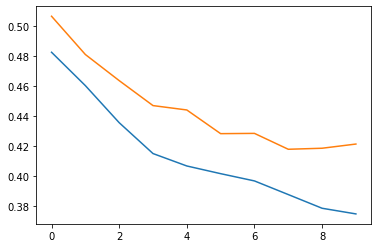

In [103]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [119]:
val_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None))>

### Проверим качество обученной модели визуально.

In [109]:
img, mask = next(iter(val_ds.take(1)))

In [121]:
mask.shape

TensorShape([8, 256, 256, 1])

In [122]:
img.shape

TensorShape([8, 256, 256, 3])

In [110]:
mask_pred = model.predict(img)

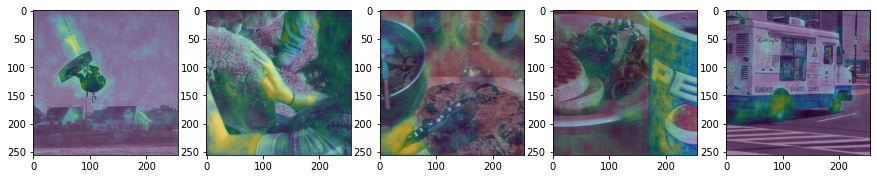

In [111]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask_pred[..., 0][i], alpha=0.5)
plt.show()

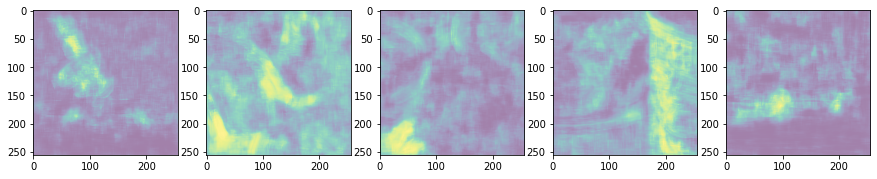

In [114]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    # ax.imshow(img[i])
    ax.imshow(mask_pred[..., 0][i], alpha=0.5)
plt.show()

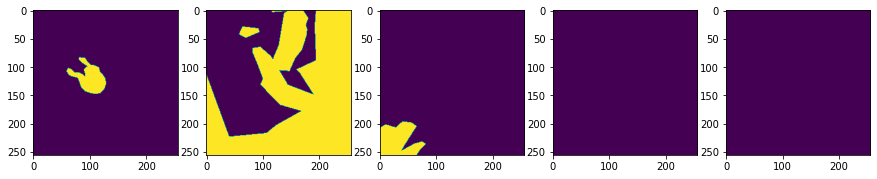

In [123]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    # ax.imshow(img[i])
    ax.imshow(mask[...,0][i])
plt.show()

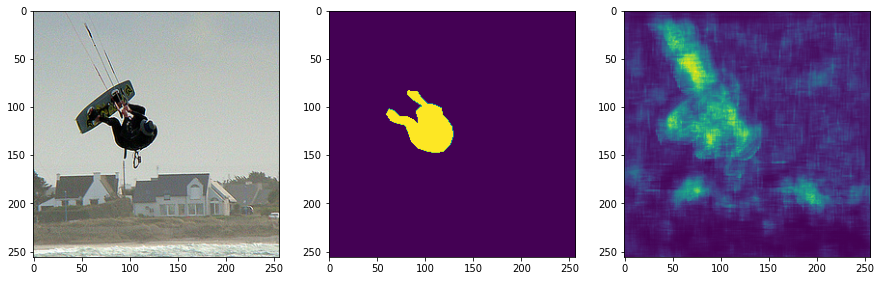

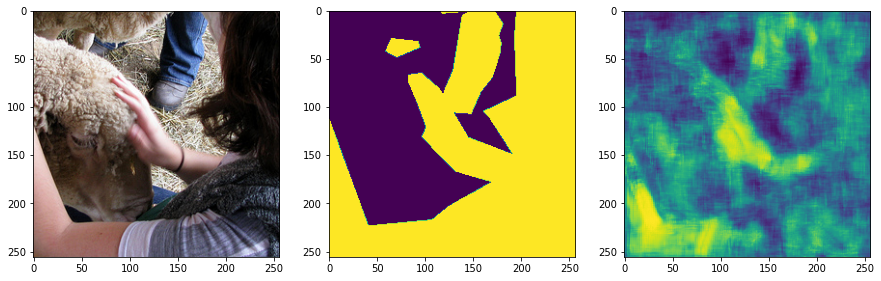

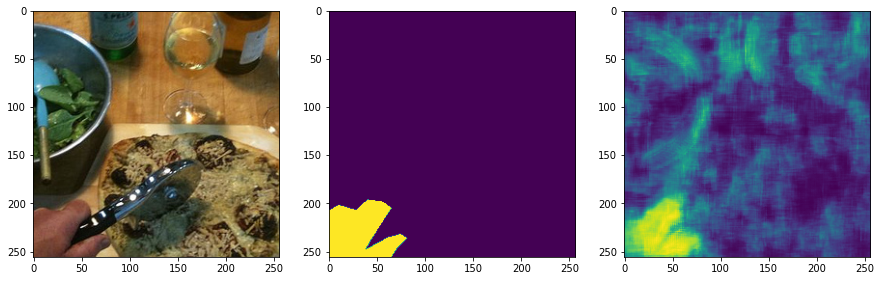

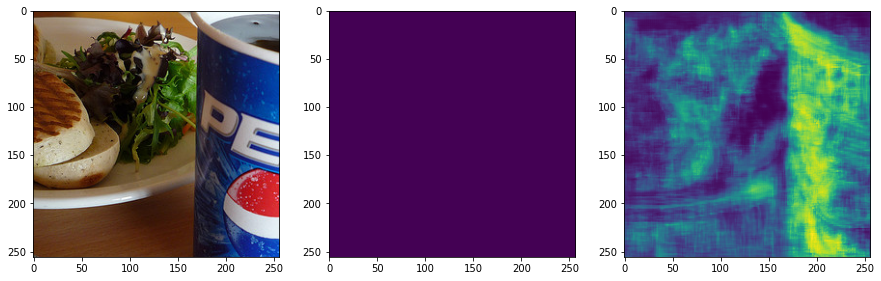

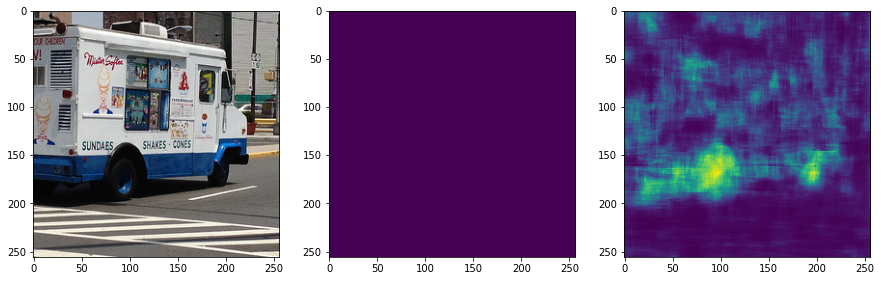

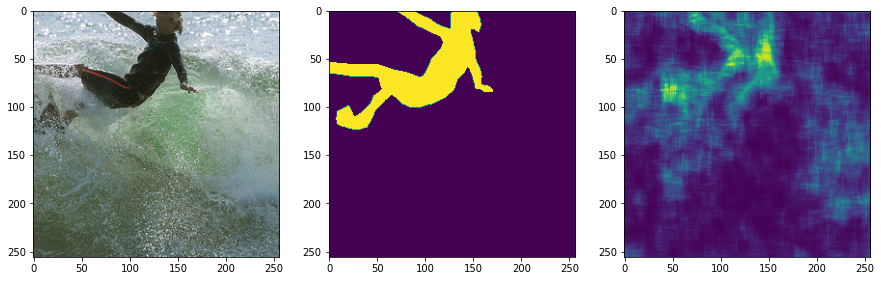

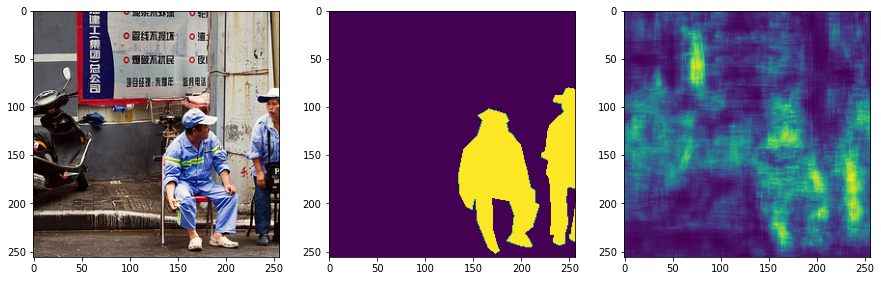

In [127]:
for i in range(7):
    fig, ax  = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(img[i])
    ax[1].imshow(mask[...,0][i])
    ax[2].imshow(mask_pred[..., 0][i])
    plt.show()

__Выводы:__
1. Из-за большого объема датасета пришлось обрезать датасет.
2. Случайный кроп позволяет эффективнее обучать нейросеть.
3. При увеличении батча, скорость обучения возрастает.
4. При увеличении количества эпох обучения качество семантической сегментации увеличивается. Края распознанного сегмента становятся более четкими.
5. Модель нуждается в доработке